# **RotNet Classifier Creation**

In [9]:
# import
import torch
import torchvision
import nin
import rotnet_config
from dataloader import DataLoader, GenericDataset
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
from utils import load_data_for_rotnet, load_data_for_mnist, nbr_total_pred
from torchsummary import summary

In [10]:
#data loading
dloader_train, dloader_test = load_data_for_rotnet()

In [11]:
# model creation
rotnet_nin = nin.create_model(rotnet_config.net_opt)
if torch.cuda.is_available():
    rotnet_nin.cuda()

In [12]:
#model summary
summary(rotnet_nin, (1,28,28), batch_size=32, device='cuda' )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [32, 192, 28, 28]           4,800
       BatchNorm2d-2          [32, 192, 28, 28]             384
              ReLU-3          [32, 192, 28, 28]               0
        BasicBlock-4          [32, 192, 28, 28]               0
            Conv2d-5          [32, 160, 28, 28]          30,720
       BatchNorm2d-6          [32, 160, 28, 28]             320
              ReLU-7          [32, 160, 28, 28]               0
        BasicBlock-8          [32, 160, 28, 28]               0
            Conv2d-9           [32, 96, 28, 28]          15,360
      BatchNorm2d-10           [32, 96, 28, 28]             192
             ReLU-11           [32, 96, 28, 28]               0
       BasicBlock-12           [32, 96, 28, 28]               0
        MaxPool2d-13           [32, 96, 15, 15]               0
           Conv2d-14          [32, 192,

In [13]:
params = rotnet_nin.parameters()
optimizer = torch.optim.Adam(params, lr=0.003)


In [14]:
# training and testing
train_loss = []
train_accuracy = []

test_loss = []
test_accuracy = []

# loss function
cross_entropy_loss = torch.nn.CrossEntropyLoss()
# number of epoch
nb_epoch = rotnet_config.config['max_num_epochs']


def train(epoch):
    rotnet_nin.train()
    epoch_loss = []
    total_label = 0
    total_correct_pred = 0
    for _, batch in enumerate(tqdm(dloader_train(epoch), ascii=True, desc=f"epoch_{epoch + 1}/{nb_epoch}")):
        dataX = torch.FloatTensor()
        labels = torch.LongTensor()
        dataX.resize_(batch[0].size()).copy_(batch[0])
        labels.resize_(batch[1].size()).copy_(batch[1])

        dataX_var = torch.autograd.Variable(dataX)
        labels_var = torch.autograd.Variable(labels, requires_grad=False)
        if torch.cuda.is_available():
            dataX_var = dataX_var.cuda()
            labels_var = labels_var.cuda()
        pred_var = rotnet_nin(dataX_var)

        # compute the loss
        loss = cross_entropy_loss(pred_var, labels_var)
        epoch_loss.append(loss.item())

        # compute the number of correct prediction
        total_correct_pred += nbr_total_pred(pred_var, labels_var)
        total_label += labels_var.size(0)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    epoch_loss = sum(epoch_loss) / len(epoch_loss)  # len(dloader_train)
    accuracy = 100.0 * total_correct_pred / total_label
    train_loss.append(epoch_loss)
    train_accuracy.append(accuracy)

    # create checkpoint (it will be use later for transfer learning stage)
    torch.save(
        {
            'epoch': epoch,
            'model_state_dict': rotnet_nin.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss[-1]
        }, f"./models_save_dir/rotnet/model_epoch_{epoch + 1}"
    )

    print(f"Train Loss: {epoch_loss} | Accuracy: {accuracy} %")


def test(epoch):
    rotnet_nin.eval()
    with torch.no_grad():
        epoch_loss = []
        total_label = 0
        total_correct_pred = 0
        for _, batch in enumerate(tqdm(dloader_test(epoch), ascii=True, desc=f"Test of epoch_{epoch + 1}")):
            dataX = torch.FloatTensor()
            labels = torch.LongTensor()
            dataX.resize_(batch[0].size()).copy_(batch[0])
            labels.resize_(batch[1].size()).copy_(batch[1])
            dataX_var = torch.autograd.Variable(dataX)
            labels_var = torch.autograd.Variable(labels, requires_grad=False)
            if torch.cuda.is_available():
                dataX_var = dataX_var.cuda()
                labels_var = labels_var.cuda()
            pred_var = rotnet_nin(dataX_var)

            # compute the loss
            loss = cross_entropy_loss(pred_var, labels_var)
            epoch_loss.append(loss.item())

            # compute the number of correct prediction
            total_correct_pred += nbr_total_pred(pred_var, labels_var)
            total_label += labels_var.size(0)
        epoch_loss = sum(epoch_loss) / len(epoch_loss)
        accuracy = 100.0 * total_correct_pred / total_label
        test_loss.append(epoch_loss)
        test_accuracy.append(accuracy)

        print(f"Test Loss: {epoch_loss} | Accuracy: {accuracy} %")


def fit(nb_epoch):
    for epoch in range(nb_epoch):
        train(epoch)
        test(epoch)


fit(nb_epoch)


epoch_1/10: 100%|##########| 1875/1875 [09:32<00:00,  3.28it/s]


Train Loss: 0.1134007720110317 | Accuracy: 95.79458333333334 %


Test of epoch_1: 100%|##########| 313/313 [00:37<00:00,  8.45it/s]


Test Loss: 0.1396011816599546 | Accuracy: 94.97 %


epoch_2/10: 100%|##########| 1875/1875 [09:34<00:00,  3.26it/s]


Train Loss: 0.062369937935099005 | Accuracy: 97.68375 %


Test of epoch_2: 100%|##########| 313/313 [00:36<00:00,  8.55it/s]


Test Loss: 0.053981314379217535 | Accuracy: 97.99 %


epoch_3/10: 100%|##########| 1875/1875 [09:34<00:00,  3.26it/s]


Train Loss: 0.052100670553992194 | Accuracy: 98.07416666666667 %


Test of epoch_3: 100%|##########| 313/313 [00:37<00:00,  8.26it/s]


Test Loss: 0.050076291648322904 | Accuracy: 98.125 %


epoch_4/10: 100%|##########| 1875/1875 [09:45<00:00,  3.20it/s]


Train Loss: 0.04586127873696387 | Accuracy: 98.3275 %


Test of epoch_4: 100%|##########| 313/313 [00:38<00:00,  8.18it/s]


Test Loss: 0.04678256711297737 | Accuracy: 98.2575 %


epoch_5/10: 100%|##########| 1875/1875 [09:42<00:00,  3.22it/s]


Train Loss: 0.04022025945720573 | Accuracy: 98.51791666666666 %


Test of epoch_5: 100%|##########| 313/313 [00:37<00:00,  8.27it/s]


Test Loss: 0.04426100999009037 | Accuracy: 98.385 %


epoch_6/10: 100%|##########| 1875/1875 [09:35<00:00,  3.26it/s]


Train Loss: 0.03626938004627203 | Accuracy: 98.6525 %


Test of epoch_6: 100%|##########| 313/313 [00:36<00:00,  8.58it/s]


Test Loss: 0.04987086862408981 | Accuracy: 98.195 %


epoch_7/10: 100%|##########| 1875/1875 [09:34<00:00,  3.26it/s]


Train Loss: 0.03349982850073526 | Accuracy: 98.75208333333333 %


Test of epoch_7: 100%|##########| 313/313 [00:36<00:00,  8.48it/s]


Test Loss: 0.04419894096057173 | Accuracy: 98.465 %


epoch_8/10: 100%|##########| 1875/1875 [09:35<00:00,  3.26it/s]


Train Loss: 0.031075553115534907 | Accuracy: 98.83791666666667 %


Test of epoch_8: 100%|##########| 313/313 [00:36<00:00,  8.48it/s]


Test Loss: 0.036214365935757956 | Accuracy: 98.705 %


epoch_9/10: 100%|##########| 1875/1875 [09:34<00:00,  3.26it/s]


Train Loss: 0.029330095828836784 | Accuracy: 98.91958333333334 %


Test of epoch_9: 100%|##########| 313/313 [00:37<00:00,  8.38it/s]


Test Loss: 0.04381413848394864 | Accuracy: 98.425 %


epoch_10/10: 100%|##########| 1875/1875 [09:40<00:00,  3.23it/s]


Train Loss: 0.026682126808686493 | Accuracy: 99.01208333333334 %


Test of epoch_10: 100%|##########| 313/313 [00:37<00:00,  8.35it/s]

Test Loss: 0.03683005833483938 | Accuracy: 98.71 %


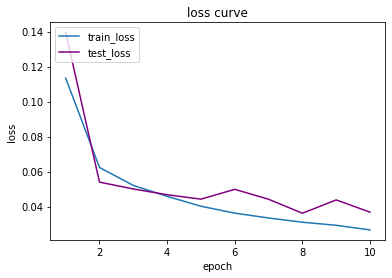

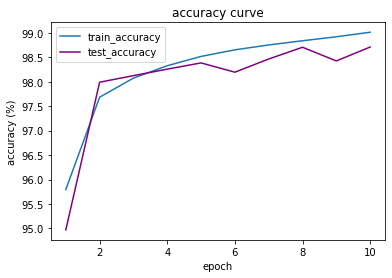

In [15]:
# visualise train loss and accuracy plot
plt.plot(np.linspace(1, nb_epoch, nb_epoch).astype(int), train_loss, label='train_loss')
fig = plt.plot(np.linspace(1, nb_epoch, nb_epoch).astype(int), test_loss, label='test_loss', c='purple')
plt.legend(loc='upper left')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("loss curve")
plt.savefig('./figs/loss_curve_rot_model')
plt.show()
print()
plt.plot(np.linspace(1, nb_epoch, nb_epoch).astype(int), train_accuracy, label='train_accuracy')
plt.plot(np.linspace(1, nb_epoch,nb_epoch).astype(int), test_accuracy, label='test_accuracy', c='purple')
plt.legend(loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy (%)')
plt.title("accuracy curve")
plt.savefig('./figs/accuracy_curve_rot_model')
plt.show()

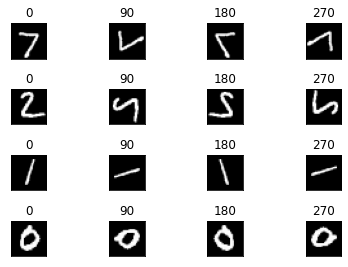

In [16]:
# prediction after training
for b in dloader_test(0):
    data, label = b
    break

inv_transform = dloader_train.inv_transform

if torch.cuda.is_available():
    data_cuda = data.cuda()
else:
    data_cuda = data
rotnet_nin.eval()
with torch.no_grad():
    _, pred = rotnet_nin(data_cuda).data.max(1)
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.tight_layout()
        if pred[i].item() == 0:
            angle = 0
        elif pred[i].item() == 1:
            angle = 90
        elif pred[i].item() == 2:
            angle = 180
        else:
            angle = 270
        plt.tight_layout()
        plt.title(f"{angle}")
        fig = plt.imshow(inv_transform(data[i]).squeeze(), cmap='gray')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)

    plt.savefig('./figs/rot_img_4x4_pred_after_training')
    plt.show()